In [1]:
import requests
import json

def get_rating_data(ratings_id, host="http://localhost:9877"):
    response = requests.get(f"{host}/ratings?show_scores=True")
    ratings = response.json()
    rating = next(r for r in ratings if r['id'] == ratings_id)

    response = requests.get(f"{host}/testsets/{rating['testset_id']}")
    content = response.json()

    questions_json = content["questions"]
    questions = json.loads(questions_json)

    scores_json = rating['scores']
    scores = json.loads(scores_json)

    return rating, questions, scores

In [2]:
def merge_questions_and_scores(questions, scores):
    """
    Merge questions and scores into a single DataFrame.
    
    Args:
        questions (dict): Dictionary containing questions data
        scores (dict): Dictionary containing scores data
        
    Returns:
        pd.DataFrame: Merged DataFrame containing both questions and scores
    """
    import pandas as pd
    
    df_scores = pd.DataFrame(scores)
    reshaped_scores = df_scores.to_dict('records')

    df_questions = pd.DataFrame(questions)
    reshaped_questions = df_questions.reset_index().rename(columns={'index': 'id'}).to_dict('records')

    if not len(reshaped_questions) == len(reshaped_scores):
        raise ValueError("Number of questions and scores do not match")

    # Create a list to store merged entries
    merged_entries = []

    # Iterate through reshaped_questions and merge with corresponding scores
    for i, question in enumerate(reshaped_questions):
        if i < len(reshaped_scores):
            merged_entry = question.copy()  # Start with question entry
            merged_entry.update(reshaped_scores[i])  # Update with score data
            merged_entries.append(merged_entry)
        else:
            merged_entries.append(question)  # Add question without scores if no matching score exists

    # Convert back to DataFrame for easier manipulation if needed
    return pd.DataFrame(merged_entries)

def get_entry_by_id(df, entry_id):
    """
    Get a specific entry from the DataFrame by its ID with fields in a specific order.
    
    Args:
        df (pd.DataFrame): The merged DataFrame containing questions and scores
        entry_id (int): The ID of the entry to retrieve
        
    Returns:
        dict: The row matching the given ID with ordered fields, or None if not found
    """
    matching_row = df[df['id'] == entry_id]
    
    if matching_row.empty:
        return None

    # Convert to records and get first item
    record = matching_row.to_dict('records')[0]
    
    # Define order of fields
    ordered_fields = [
        'id',
        'question',
        'reference_answer',
        'response',
        'reference_context',
        'retrieved_contexts',
        'answer_relevancy',
        'context_precision', 
        'faithfulness',
        'context_recall'
    ]
    
    # Create ordered dictionary with specified fields first
    ordered_record = {field: record[field] for field in ordered_fields if field in record}
    
    # Add any remaining fields that weren't in the ordered list
    remaining_fields = {k: v for k, v in record.items() if k not in ordered_fields}
    ordered_record.update(remaining_fields)
    
    return ordered_record


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(df, filter_zero=False, figsize=(12, 10)):
    """
    Plot distributions of evaluation scores with optional zero value filtering.
    
    Args:
        df (pd.DataFrame): DataFrame containing the scores
        filter_zero (bool): If True, filter out scores that are 0.0
        figsize (tuple): Figure size as (width, height)
        
    Returns:
        matplotlib.figure.Figure: The created figure object
    """
    # The scores to plot
    scores_to_plot = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Plot the distribution for each score
    for i, score in enumerate(scores_to_plot):
        data = df[score]
        if filter_zero:
            data = data[data != 0.0]
            
        sns.histplot(data, ax=axes[i], kde=True, bins=20)
        axes[i].set_title(f'Distribution of {score}')
        axes[i].set_xlabel(score)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 1)
        
        # Add count of filtered values if filtering is enabled
        if filter_zero:
            total = len(df[score])
            filtered = total - len(data)
            axes[i].text(0.05, 0.95, f'Filtered: {filtered}/{total} zeros',
                        transform=axes[i].transAxes, verticalalignment='top')
    
    plt.tight_layout()
    return fig

## OpenAi judged by Deepseek-v3 32B

### 10 Dok

#### 15 Qestions

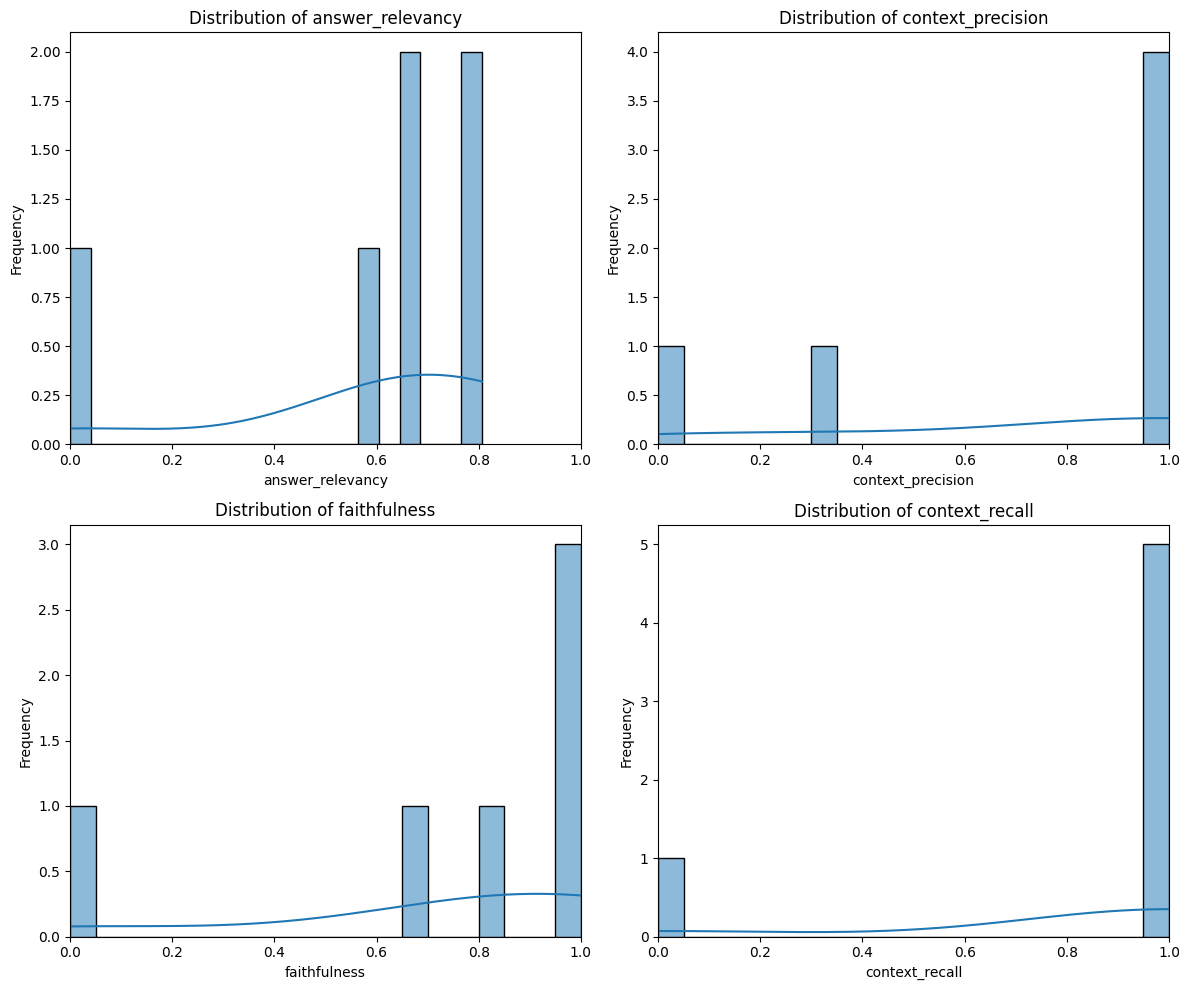

In [4]:
ratings_id = 15
rating, questions, scores = get_rating_data(ratings_id)
df_merged_10_15 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_10_15)

### 30 Questions

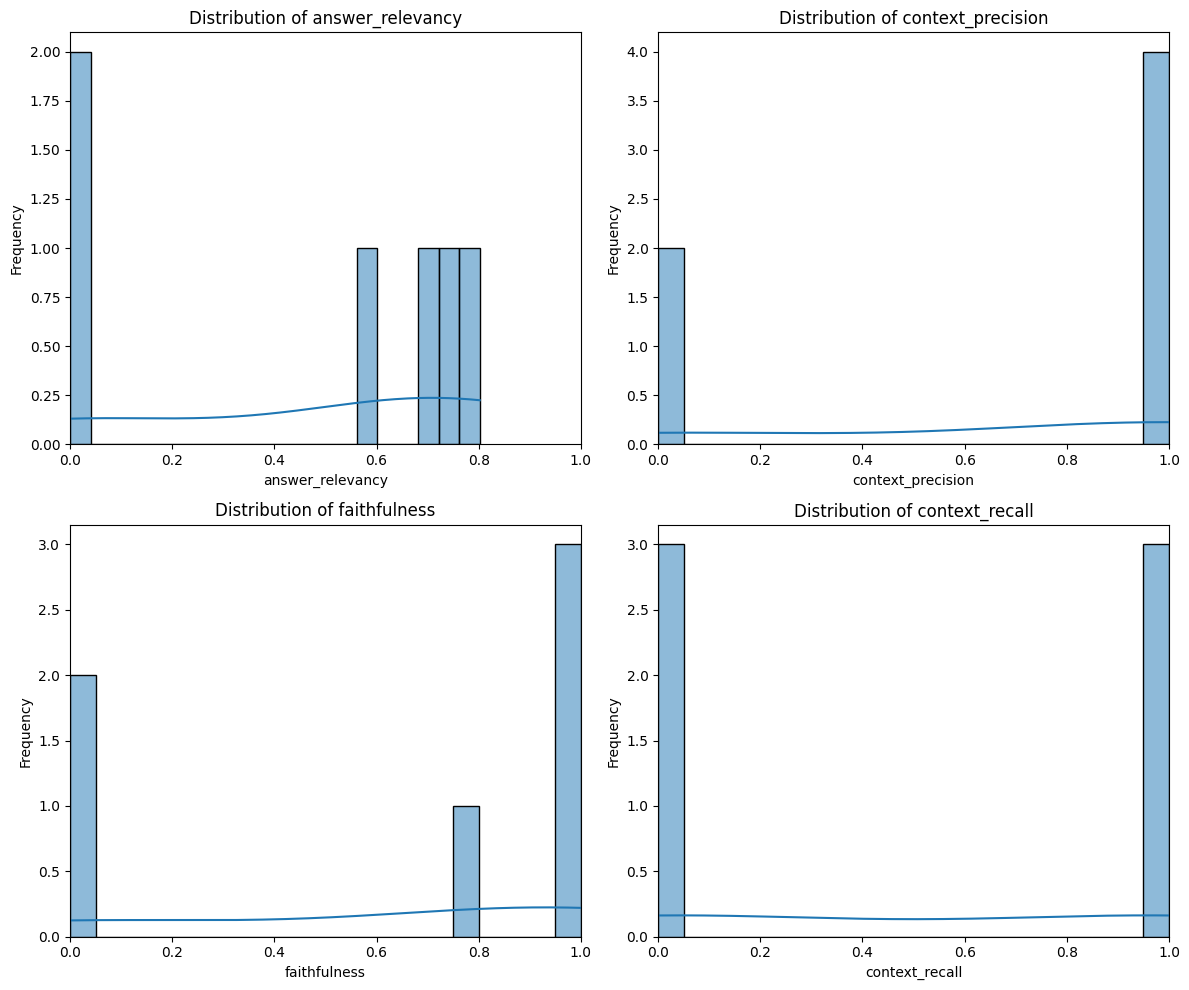

In [9]:
ratings_id = 124#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_10_30 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_10_15)

**96646631-8dee-4aa6-864e-b4ecb5c91510**  
Erwartet aber an sich leider flasch, warum die relevancy hier 0 ist erschließt sich mir nicht

In [13]:
get_entry_by_id(df_merged_10_30, "96646631-8dee-4aa6-864e-b4ecb5c91510")

{'id': '96646631-8dee-4aa6-864e-b4ecb5c91510',
 'question': 'Als Gründer eines Startups, das sich mit zukunftsweisenden Technologien beschäftigt, möchte ich wissen, ob das Unternehmen nach der Förderung weitergeführt wird?',
 'reference_answer': 'Ja, das Unternehmen wird weitergeführt.',
 'response': 'Ja, das Unternehmen wird nach der Förderung weitergeführt.',
 'reference_context': 'Document 24: zukunftsträchtiger Technologiebereich\n\n  neue innovativen Dienstleistungen\n\n  neue innovativen Geschäftsmodelle\n\nWeiterführung des Unternehmens nach der Förderung? \n\n  Ja, das Unternehmen wird weitergeführt.\n\n  Nein, das Unternehmens bzw. die Gründungsidee \n\n      wird/ wurde aufgegeben.\n\nEs wurden mindestens drei Treffen mit dem Coach abgehalten\n\n  Ja, die Treffen wurden abgehalten.\n\n  Nein, es wurden weniger Treffen abgehalten weil:  \n\n\n\n\n\nMusste das Vorhaben während der Förderung nochmals vor die Jury?\n\n  Nein.\n\n  Ja, weil: Vom Coach ein mangelnder Vortschritt de

**1da03ae9-3ed8-409c-92be-4355b2354f0a**  
Die Frage wurde an sich richtig beantwortet, die context Scores sind wie zu erwarten 0 aber die anderen Metriken geben zu recht keinen 0 Score

In [14]:
get_entry_by_id(df_merged_10_30, "1da03ae9-3ed8-409c-92be-4355b2354f0a")

{'id': '1da03ae9-3ed8-409c-92be-4355b2354f0a',
 'question': 'An welche Zielgruppe richtet sich das Angebot von Develop 4 Future, unter Berücksichtigung der Tatsache, dass es sich explizit nicht an Verbraucher im Sinne des § 13 BGB wendet?',
 'reference_answer': 'Das Angebot von Develop 4 Future richtet sich explizit nicht an Verbraucher im Sinne des § 13 BGB.',
 'response': 'Das Angebot von Develop 4 Future richtet sich an Schulen, insbesondere zunächst an Grundschulen. In Zukunft ist zudem geplant, das Angebot auf weiterführende Schulen und Kindertageseinrichtungen auszuweiten. Die Zielgruppe sind somit Bildungseinrichtungen beziehungsweise deren Träger, also juristische Personen oder Organisationen, nicht an Verbraucher im Sinne des § 13 BGB (Privatpersonen).',
 'reference_context': 'Document 99: Develop 4 Future\n\n\t\t\tDevelop 4 Future\n\n\n\nAllgemeine Geschäftsbedingunge Develop 4 Future\n\n§ 1 Geltungsbereich\n\n(1) Die folgenden AGB regeln das Vertragsverhältnis zwischen Leon 

**37cc9d92-4924-435d-8372-0158dbcfdfc2**  
Der relevante Kontext wurde nicht gefeundn die Frage jedoch PLausibel beantwortet

In [15]:
get_entry_by_id(df_merged_10_30, "37cc9d92-4924-435d-8372-0158dbcfdfc2")

{'id': '37cc9d92-4924-435d-8372-0158dbcfdfc2',
 'question': 'Was garantiert diese Firma?',
 'reference_answer': 'D4f garantiert nicht, dass von ihnen eingesetzte oder bereitgestellte Hard- und Software den Anforderungen des Kunden genügt, für bestimmte Anwendungen geeignet ist, und dass diese absturz-, fehler- und frei von Schadsoftware ist.',
 'response': 'Die Firma garantiert, dass die Server von Hosteurope in Deutschland stehen und somit datenschutzkonform sind. Außerdem werden alle Updates inklusive Sicherheitsupdates automatisch installiert (vorausgesetzt, der Kunde hat ein monatliches Abonnement abgeschlossen). Zusätzlich gibt es eine Dienstleistungsgarantie und es wird eine branchenübliche Verschwiegenheitsklausel für Mitarbeiter eingesetzt, um die Software zu schützen.',
 'reference_context': 'Document 117: (2) D4f weist darauf hin, dass es nach dem derzeitigen Stand der Technik nicht möglich ist, Hard- und Software so zu erstellen, dass sie in allen Anwendungskombinationen feh

### 100 Dok

#### 50 Questions

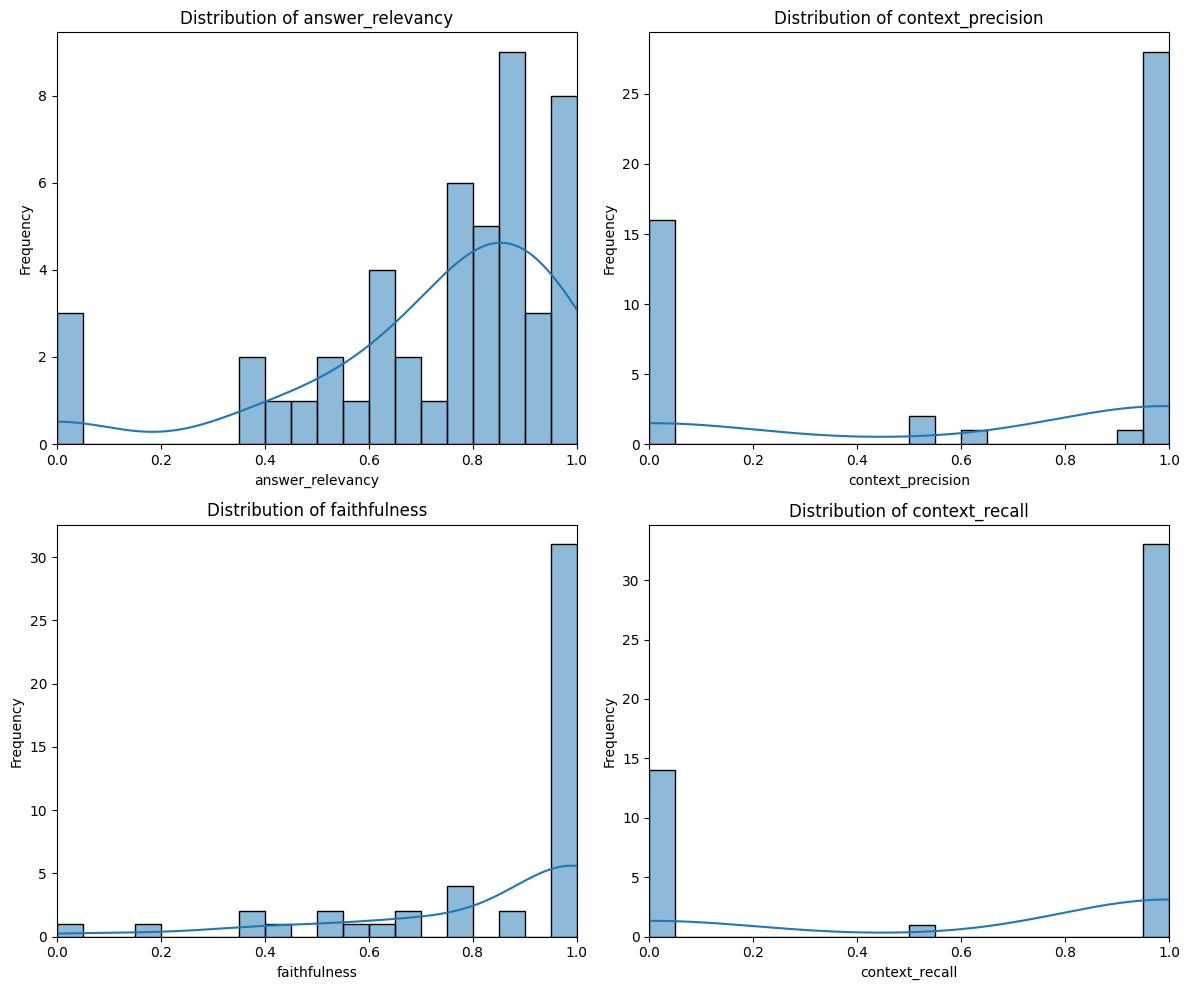

In [17]:
ratings_id = 125
rating, questions, scores = get_rating_data(ratings_id)
df_merged_100_50 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_100_50)

**b949535d-7eed-4500-9972-9a93c5c42463**  
Das ergebniss ist wie zu erwarte, der Kontext konnte nicht gefunden werden aber die Frage ist immer noch Sinnvoll

In [19]:
get_entry_by_id(df_merged_100_50, "b949535d-7eed-4500-9972-9a93c5c42463")

{'id': 'b949535d-7eed-4500-9972-9a93c5c42463',
 'question': 'Was ist d4f berechtigt zu tun, wenn der Vertrag zwischen dem Kunden und d4f beendet wird?',
 'reference_answer': 'd4f ist berechtigt, die Domains in die direkte Verwaltung der jeweiligen Vergabestelle bzw. des Registrars zu überführen oder die Domains im Namen des Kunden freizugeben.',
 'response': 'Laut dem gegebenen Kontext ist d4f berechtigt, den Kunden nach Maßgabe einer separaten Vereinbarung beim Umzug der Website auf eigene Server zu unterstützen. Weitergehende Supportleistungen oder Weiterentwicklungen der Dienste und Funktionalitäten erfolgen jedoch nicht.',
 'reference_context': 'Document 234: Frist schriftlich zum Verfahren mit den Domains zu erklären, ist d4f berechtigt, die Domains in die direkte Verwaltung der jeweiligen Vergabestelle bzw. des Registrars zu überführen oder die Domains im Namen des Kunden freizugeben. Entsprechendes gilt bei jeder Beendigung des Vertrags zwischen dem Kunden und d4f, gleich aus we

**52091bfd-215c-43b1-887d-3227aedce44d**  
Wieder wurde der relevante Kontext nicht gefunden, jedoch ist die Antwort relevant

In [20]:
get_entry_by_id(df_merged_100_50, "52091bfd-215c-43b1-887d-3227aedce44d")

{'id': '52091bfd-215c-43b1-887d-3227aedce44d',
 'question': 'An wen richten sich diese?',
 'reference_answer': 'Das Angebot von Develop 4 Future richtet sich ausdrücklich nicht an Verbraucher.',
 'response': 'Die im Kontext genannten Produkte und Dienstleistungen richten sich in erster Linie an Schulen beziehungsweise an Verantwortliche für Schul-Webseiten (wie Schulleiter:innen, Schulträger oder IT-Beauftragte von Schulen). Die Zielgruppe sind also Institutionen im Bildungsbereich, insbesondere Schulen, die Wert auf qualitativ hochwertige, rechtssichere und individuell anpassbare Webpräsenzen legen.',
 'reference_context': 'Document 248: Develop 4 Future\n\n\t\t\tDevelop 4 Future\n\n\n\nAllgemeine Geschäftsbedingunge Develop 4 Future\n\n§ 1 Geltungsbereich\n\n(1) Die folgenden AGB regeln das Vertragsverhältnis zwischen Leon Bartz, Heilerstraße 63, 51647 Windhagen, handelnd unter Develop 4 Future, (nachfolgend d4f genannt) und dem jeweiligen Kunden. Diese AGB gelten auch für zukünftige

**1835da68-aea3-4d94-9954-15338e9dd6ab**  
Hier lässt die Frage auch wieder schwer benatworten da der relevante Kontext nicht gefunden wird. Es wird aus dem gefunden Kontext jedoch wieder eine plausible Antwort in diesem Fall sehr lange antwort produziert.

In [21]:
get_entry_by_id(df_merged_100_50, "1835da68-aea3-4d94-9954-15338e9dd6ab")

{'id': '1835da68-aea3-4d94-9954-15338e9dd6ab',
 'question': 'Wie wird das Produkt Infofuchs an die Kunden verkauft und welche zusätzlichen Kosten sind nach dem Kauf enthalten, insbesondere unter Berücksichtigung der Anfängerfreundlichkeit und der speziellen Funktionen wie der Abwesenheitsanzeige?',
 'reference_answer': 'Das System wird direkt an die Kunden als Software as a Service verkauft. Das Produkt wird einmalig beim Verkauf mit einer Installationsgebühr versehen und danach mit monatlich laufenden Serviceverträgen. In diesen Serviceverträgen sind die Kosten für den Server und dessen Wartung enthalten.',
 'response': 'Das Produkt Infofuchs wird folgendermaßen an die Kunden verkauft:\n\n**1. Akquise-Prozess:**\n- Es wird zunächst das Interesse durch einen Anruf im Schulsekretariat angefragt, mit der Bitte um Durchstellung an die Schulleitung.\n- Besteht Interesse, wird eine standardisierte Informationsmail versendet und weitere Fragen beantwortet.\n- Falls keine Rückmeldung seitens 

#### 100 Questions

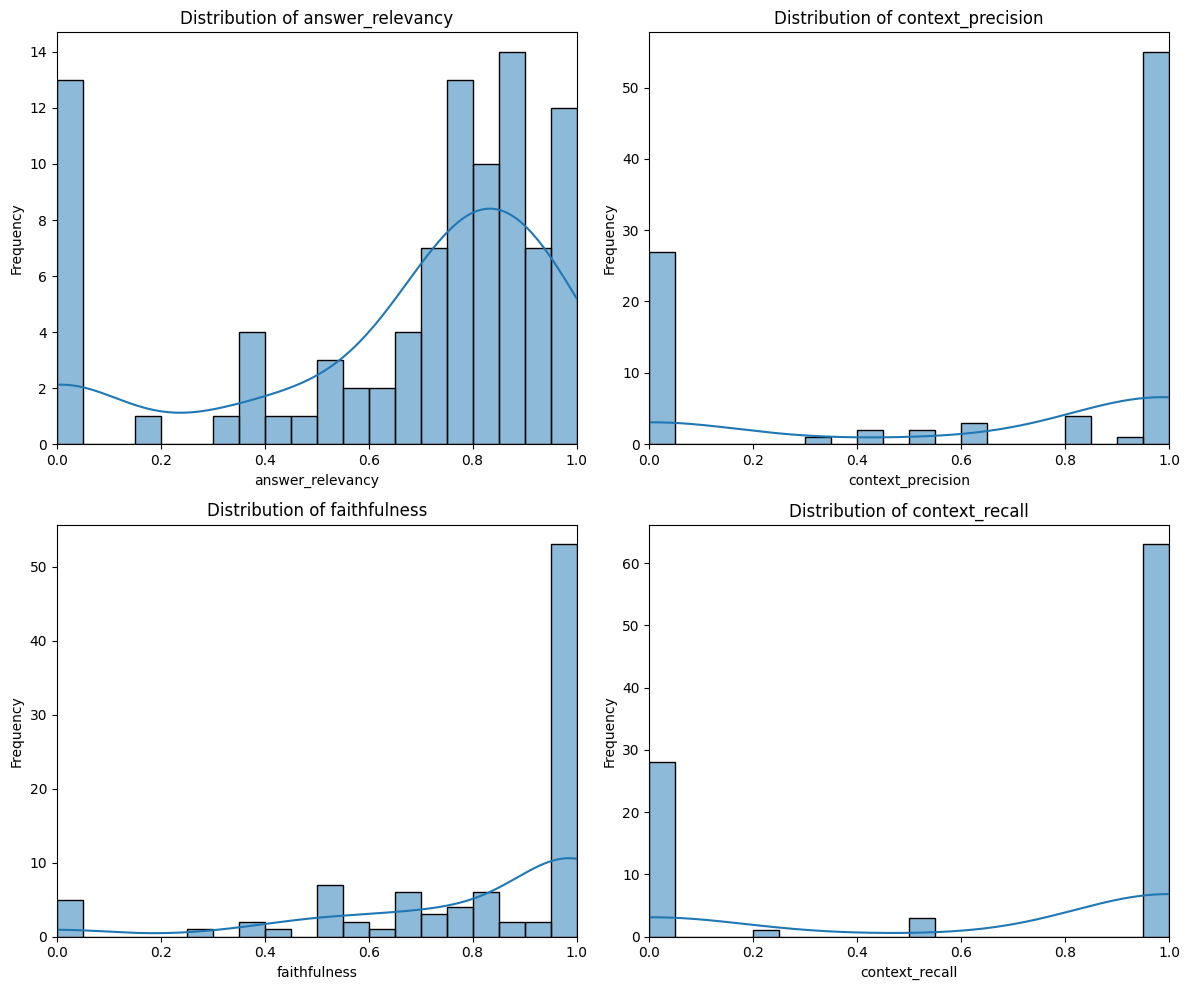

In [22]:
ratings_id = 127
rating, questions, scores = get_rating_data(ratings_id)
df_merged_100_100 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_100_100)

**375134c8-45fd-4491-9f17-0330dd0d5ffa**  
Guter Fall

In [24]:
get_entry_by_id(df_merged_100_100, "375134c8-45fd-4491-9f17-0330dd0d5ffa")

{'id': '375134c8-45fd-4491-9f17-0330dd0d5ffa',
 'question': 'Kannst du mir erklären, was das besondere Merkmal des neuen Schulwebseiten Systems ist, das ich als Lehrer verwenden werde, um Abwesenheitsmeldungen schnell und einfach zu veröffentlichen?',
 'reference_answer': 'Das besondere Merkmal des entwickelten Schulwebseiten Systems ist die Abwesenheitsmeldung.',
 'response': 'Das besondere Merkmal des neuen Schulwebseiten-Systems ist, dass die Erziehungsberechtigten die Abwesenheitsanzeigen ihrer Kinder direkt über ein Onlineportal (Infofuchs) einreichen können. Dadurch entfällt für das Sekretariat und für die Lehrkräfte ein großer Teil der bisherigen telefonischen oder schriftlichen Entschuldigung. Die eingereichten Entschuldigungen liegen digital und strukturiert vor und können vom Sekretariat mit nur einem Klick klassenweise exportiert und als geordnete Liste ausgedruckt werden. \n\nFür dich als Lehrer bedeutet das, dass Abwesenheitsmeldungen schnell, einfach und übersichtlich onl

### 400 Dok

#### 150 Questions

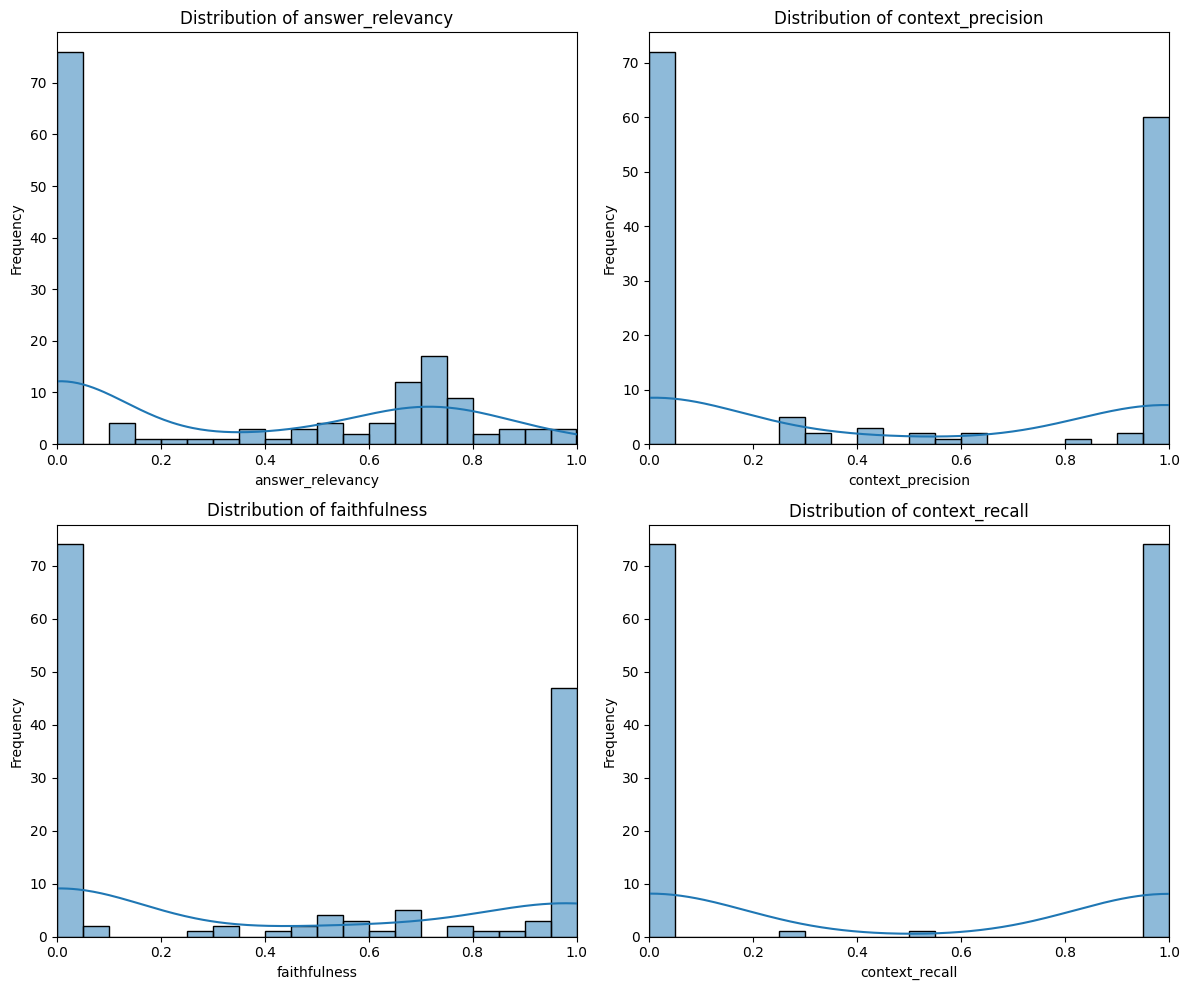

In [25]:
ratings_id = 81
rating, questions, scores = get_rating_data(ratings_id)
df_merged_400_150 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_150)

**f0199abb-dd71-4f2e-bf71-1ad847a96503**  
Trotz der schlecht gestellten Frage wurde der relevante context gefunden. 

In [26]:
get_entry_by_id(df_merged_400_150, "f0199abb-dd71-4f2e-bf71-1ad847a96503")

{'id': 'f0199abb-dd71-4f2e-bf71-1ad847a96503',
 'question': 'Bitte identifizieren Sie anhand des bereitgestellten Kontextes die Middleware, die explizit für das Setzen von Cache-Headern verantwortlich ist, und erläutern Sie zusätzlich, wie Sie diese Middleware in einer Laravel-Route korrekt einbinden würden. Geben Sie dabei den vollständigen Klassennamen an.',
 'reference_answer': "'cache.headers' => \\Illuminate\\Http\\Middleware\\SetCacheHeaders::class",
 'response': "Die Middleware, die explizit für das Setzen von Cache-Headern verantwortlich ist, ist `\\Illuminate\\Http\\Middleware\\SetCacheHeaders`. Der vollständige Klassenname wird im Kontext angegeben.\n\nUm diese Middleware in einer Laravel-Route zu verwenden, müssen Sie zunächst sicherstellen, dass sie im `Kernel.php` unter den Middleware-Gruppen oder Route-Middleware registriert ist, falls dies noch nicht der Fall ist. Wenn Sie die Middleware speziell für eine Route einbinden möchten, können Sie den Middleware-Bezeichner dire

**1508341c-666d-43b9-a684-66214718b6f5**  
Überraschender weise wurde der richtige Kontext gefunden, die Frage lässt sich aber immer noch nicht sinnvol beantworten

In [27]:
get_entry_by_id(df_merged_400_150, "1508341c-666d-43b9-a684-66214718b6f5")

{'id': '1508341c-666d-43b9-a684-66214718b6f5',
 'question': 'Hallo, ich bin gerade dabei, einen Finanzbericht für unser Team bei Develop 4 Future zu erstellen und prüfe dazu die aktuellen Umsatz- und Rohertragszahlen aus den letzten Geschäftsunterlagen. Kannst du mir sagen, wie hoch die Umsatzerlöse im Geschäftsfeld 2 für erweiterten Support laut den bereitgestellten Daten sind?',
 'reference_answer': 'Die Umsatzerlöse im Geschäftsfeld 2 für erweiterten Support betragen laut den bereitgestellten Daten 0.',
 'response': "I don't know.",
 'reference_context': 'Document 4974: 2280 280 2420 1490 490 1560 560 1630 Umsatzerlöse Geschäftsfeld 2 erweiteter support 0 0 0 0 0 0 0 0 0 0 0 0 0 Umsatzerlöse Geschäftsfeld 3 0 0 0 0 0 0 0 0 0 0 0 0 0 Umsatzerlöse ( Summe ) 12990 0 1070 70 1140 2280 280 2420 1490 490 1560 560 1630 Waren-/Materialeinsatz 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 Rohertrag 12990 0 1070 70 1140 2280 280 2420 1490 490 1560 560 1630 Feste Private Einnahmen -10800 -900 -900 -900 -900 -

**38528bf1-8e6d-4c73-8f6c-8e94a08113e7**  
Die Frage war zu wage und die Antwort ist wie zu erwarten aufgrunde des nicht gefundenen contextes 0

In [28]:
get_entry_by_id(df_merged_400_150, "38528bf1-8e6d-4c73-8f6c-8e94a08113e7")

{'id': '38528bf1-8e6d-4c73-8f6c-8e94a08113e7',
 'question': 'Was passiert mit dem padding-right Stil von body, wenn der Code ausgeführt wird?',
 'reference_answer': 'Der ursprüngliche Wert von padding-right des body-Elements wird gespeichert und anschließend um die Breite des Scrollbalkens erhöht.',
 'response': "I don't know.",
 'reference_context': 'Document 2838: o=document.body.style.paddingRight,i=e(document.body).css("padding-right");e(document.body).data("padding-right",o).css("padding-right",parseFloat(i)+this._scrollbarWidth+"px")}e(document.body).addClass(Gt)},n._resetScrollbar=function(){var t=[].slice.call(document.querySelectorAll(te));e(t).each((function(t,n){var r=e(n).data("padding-right");e(n).removeData("padding-right"),n.style.paddingRight=r||""}));var n=[].slice.call(document.querySelectorAll(""+ee));e(n).each((function(t,n){var',
 'retrieved_contexts': ['<!DOCTYPE html>\n<html lang="de">\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" co

**0a2fbe49-d0f3-4d7b-82a6-2e333c1c3d03**  
Warum die Antwort relevancy nicht 1.0 ist erschließt sich mir nicht, die anderen werte sind nachvollziebar

In [ ]:
get_entry_by_id(df_merged_400_150, "0a2fbe49-d0f3-4d7b-82a6-2e333c1c3d03")

**9918a7df-4f20-4b7e-b02f-74d18979de62**  
Der context konnte wie zu erwarten aufgrund der ungenauen frage nicht gefunden werden

In [30]:
get_entry_by_id(df_merged_400_150, "9918a7df-4f20-4b7e-b02f-74d18979de62")

{'id': '9918a7df-4f20-4b7e-b02f-74d18979de62',
 'question': "Bitte beschreibe möglichst genau, welche Art von Information in der Tabellenspalte mit dem Attribut 'data-timeago' angezeigt wird, und erläutere zusätzlich, wie sich der angezeigte Wert auf den tatsächlichen Zeitstempel bezieht. Gehe dabei auch darauf ein, ob und wie sich diese Anzeige im Laufe der Zeit dynamisch verändert.",
 'reference_answer': "In der Spalte mit dem Attribut 'data-timeago' wird angezeigt, wie viel Zeit seit dem Erstellungszeitpunkt des Eintrags vergangen ist (z.B. 'vor 5 Minuten').",
 'response': "I don't know.",
 'reference_context': 'Document 3593: "+t._s(e.entry.content.composers?e.entry.content.composers.length:0)+"\\n        ")]),t._v(" "),n("td",{staticClass:"table-fit",attrs:{"data-timeago":e.entry.created_at}},[t._v(t._s(t.timeAgo(e.entry.created_at)))]),t._v(" "),n("td",{staticClass:"table-fit"},[n("router-link",{staticClass:"control-action",attrs:{to:{name:"view-preview",params:{id:e.entry.id}}}}

**15cb1c12-3944-4448-b213-426914cf3a1e**  
Der context konnte wie zu erwarten aufgrund der ungenauen frage nicht gefunden werden

In [31]:
get_entry_by_id(df_merged_400_150, "15cb1c12-3944-4448-b213-426914cf3a1e")

{'id': '15cb1c12-3944-4448-b213-426914cf3a1e',
 'question': 'Welche Funktion bietet Ln.max laut dem bereitgestellten Kontext und wie unterscheidet sich Ln.maxBy von Ln.max gemäß dem Kontext?',
 'reference_answer': 'Ln.max gibt das Maximum eines Arrays zurück, falls das Array Elemente enthält, andernfalls undefined; im Gegensatz dazu gibt Ln.maxBy das Maximum eines Arrays basierend auf einer bereitgestellten Funktion zurück, während Ln.max einfach das größte Element des Arrays zurückgibt.',
 'response': "I don't know.",
 'reference_context': 'Document 2699: o=r;return void 0!==n&&(o=(o=rc(n))<0?an(r+o,0):cn(o,r-1)),e==e?function(t,e,n){for(var r=n+1;r--;)if(t[r]===e)return r;return r}(t,e,o):Ae(t,ze,o,!0)},Ln.lowerCase=Rc,Ln.lowerFirst=Wc,Ln.lt=Za,Ln.lte=tc,Ln.max=function(t){return t&&t.length?rr(t,$c,hr):void 0},Ln.maxBy=function(t,e){return t&&t.length?rr(t,Qo(e,2),hr):void 0},Ln.mean=function(t){return Oe(t,$c)},Ln.meanBy=function(t,e){return Oe(t,Qo(e,2))},Ln.min=function(t){return

In [ ]:
ratings_id = 22#10
rating, questions, scores = get_rating_data(ratings_id)
df_merged_400_300 = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_10_15)

**ca83c38c-be8a-468c-97e3-c3f1da80ccdc**  
Erwartet 0.0

In [ ]:
get_entry_by_id(df_merged_400_300, "ca83c38c-be8a-468c-97e3-c3f1da80ccdc")

**5a8a61fc-4b29-4961-a727-bf07605db7c6**  
Wie zu erwarten 0/none

In [ ]:
get_entry_by_id(df_merged_400_300, "5a8a61fc-4b29-4961-a727-bf07605db7c6")

**57e43087-fb2b-4cbc-a29b-79edeefdb71b**  


In [ ]:
get_entry_by_id(df_merged_400_300, "57e43087-fb2b-4cbc-a29b-79edeefdb71b")

**8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c**  


In [ ]:
get_entry_by_id(df_merged_400_300, "8f2f5dfb-071c-4ba3-a8e3-ccb83b440f5c")

Nur 10 15 fertig, der rest exestiert noch NI_NUMERICHOST